# CBoW (Continuous Bag of Words)

**Descrição**  
O CBoW (Continuous Bag of Words) é um algoritmo de vetorização de palavras introduzido no contexto do Word2Vec. Seu objetivo é aprender representações vetoriais densas (embeddings) para palavras, capturando relações semânticas e sintáticas a partir do contexto em que elas aparecem em um corpus de texto.

**Objetivo**  
O principal objetivo do CBoW é prever uma palavra alvo a partir das palavras do seu contexto (vizinhança), ignorando a ordem dessas palavras. Ao resolver essa tarefa de previsão, o modelo aprende embeddings que representam palavras semanticamente semelhantes de forma próxima no espaço vetorial.

**Funcionamento**  

![CBoW](../../imagens/08_cbow.png)

No CBoW, um conjunto de palavras de contexto (por exemplo, as palavras anteriores e posteriores a uma palavra central em uma janela fixa) é convertido em vetores. Esses vetores são combinados — geralmente por média ou soma — para formar uma representação única do contexto. Essa representação é então utilizada para prever a palavra central. Durante o treinamento, os pesos da rede são ajustados de modo que palavras que compartilham contextos semelhantes passem a ter embeddings parecidos.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
from typing import List, Tuple, Dict

import random
import matplotlib.pyplot as plt
from typing import Dict, List, Union
import numpy as np

## Verificação da presença de GPU

In [2]:
print(torch.__version__) # Versão do torch
print(torch.cuda.is_available()) # Verificação de GPU
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando:", device)

2.5.1+cu121
True
NVIDIA GeForce RTX 4050 Laptop GPU
Usando: cuda


## Fixando o seed para reproducibilidade

In [3]:
def set_seed(seed: int = 42) -> None:
    """
    Fixa seeds para reprodutibilidade em Python, NumPy e PyTorch.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Garante determinismo (pode afetar performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(123)

## Funções uteis

In [4]:
def normalizar_texto(frase: str) -> List[str]:
    """
    Normaliza uma frase removendo pontuação e convertendo para minúsculas.

    Parâmetros:
    ----------
    frase : str
        Frase de entrada.

    Retorno:
    -------
    List[str]
        Lista de tokens normalizados.
    """
    frase = frase.lower()
    frase = re.sub(r"[^\w\s]", "", frase)
    return frase.split()

In [5]:
def construir_vocabulario(tokens: List[str]) -> Dict[str, int]:
    """
    Constrói um vocabulário palavra -> índice.

    Parâmetros:
    ----------
    tokens : List[str]
        Lista de tokens do corpus.

    Retorno:
    -------
    Dict[str, int]
        Mapeamento palavra -> índice.
    """
    vocabulario = sorted(set(tokens))
    return {palavra: i for i, palavra in enumerate(vocabulario)}


In [6]:
def gerar_dados_cbow(
    tokens: List[str],
    word_to_ix: Dict[str, int],
    janela: int = 2
) -> List[Tuple[List[int], int]]:
    """
    Gera pares (contexto, alvo) no formato CBOW.

    Parâmetros:
    ----------
    tokens : List[str]
        Lista de palavras do corpus.
    word_to_ix : Dict[str, int]
        Vocabulário palavra -> índice.
    janela : int, default = 2
        Tamanho da janela de contexto.

    Retorno:
    -------
    List[Tuple[List[int], int]]
        Lista de pares (contexto_indices, alvo_indice).
    """
    dados = []

    for i in range(janela, len(tokens) - janela):
        contexto = [
            word_to_ix[tokens[i + j]]
            for j in range(-janela, janela + 1)
            if j != 0
        ]
        alvo = word_to_ix[tokens[i]]
        dados.append((contexto, alvo))

    return dados

In [7]:
def mostrar_conjunto_treino(
    dados: List[Tuple[List[int], int]],
    tokens: List[str],
    word_to_ix: Dict[str, int],
    limite: int = 10
) -> None:
    """
    Exibe exemplos do conjunto de treino CBOW em formato textual e numérico.

    Parâmetros:
    ----------
    dados : List[Tuple[List[int], int]]
        Dados CBOW.
    tokens : List[str]
        Lista de tokens do corpus.
    word_to_ix : Dict[str, int]
        Vocabulário palavra -> índice.
    limite : int, default = 10
        Número máximo de exemplos a serem exibidos.
    """
    ix_to_word = {i: w for w, i in word_to_ix.items()}

    print("\nExemplos do conjunto de treino (CBOW):\n")

    for i, (contexto, alvo) in enumerate(dados[:limite]):
        contexto_texto = [ix_to_word[idx] for idx in contexto]
        alvo_texto = ix_to_word[alvo]

        print(f"Exemplo {i + 1}")
        print(f"  Contexto (texto): {contexto_texto}")
        print(f"  Contexto (índices): {contexto}")
        print(f"  Alvo (texto): '{alvo_texto}'")
        print(f"  Alvo (índice): {alvo}")
        print("-" * 50)

In [8]:
def criar_one_hot(indice: int, vocab_size: int) -> torch.Tensor:
    """
    Cria um vetor one-hot.

    Parâmetros:
    ----------
    indice : int
        Índice da palavra.
    vocab_size : int
        Tamanho do vocabulário.

    Retorno:
    -------
    torch.Tensor
        Vetor one-hot.
    """
    vetor = torch.zeros(vocab_size)
    vetor[indice] = 1.0
    return vetor

## Parte central do CBoW

In [9]:
class CBOWManual(nn.Module):
    """
    Implementação manual do modelo CBOW (Continuous Bag of Words).

    Este modelo aprende embeddings de palavras a partir do contexto,
    prevendo a palavra central com base na média dos vetores das
    palavras de contexto.

    Diferença importante:
    ---------------------
    - NÃO utiliza nn.Embedding.
    - A etapa de embedding é feita manualmente via vetores one-hot
      e multiplicação matricial.

    Estrutura do modelo:
    --------------------
    1. One-hot encoding das palavras de contexto
    2. Projeção para o espaço de embeddings (matriz W)
    3. Média dos embeddings do contexto
    4. Projeção para o espaço do vocabulário (matriz U)
    5. Retorno dos logits (antes do softmax)
    """

    def __init__(self, vocab_size: int, embedding_dim: int):
        """
        Inicializa os parâmetros do modelo.

        Parâmetros:
        ----------
        vocab_size : int
            Tamanho do vocabulário (número total de palavras).
        embedding_dim : int
            Dimensão do vetor de embedding de cada palavra.
        """
        super().__init__()

        # Matriz de embeddings
        # Shape: (vocab_size, embedding_dim)
        # Cada linha representa o embedding de uma palavra
        self.W = nn.Parameter(
            torch.randn(vocab_size, embedding_dim) * 0.01
        )

        # Matriz de saída
        # Shape: (embedding_dim, vocab_size)
        # Responsável por mapear o embedding médio para logits
        self.U = nn.Parameter(
            torch.randn(embedding_dim, vocab_size) * 0.01
        )

    def forward(self, contexto_indices: List[int]) -> torch.Tensor:
        """
        Forward pass do modelo CBOW.

        Parâmetros:
        ----------
        contexto_indices : List[int]
            Lista de índices das palavras de contexto.
            Exemplo: [2, 10, 57, 8]

        Retorno:
        -------
        torch.Tensor
            Vetor de logits de tamanho (vocab_size,),
            usado posteriormente em uma função de perda
            como CrossEntropyLoss.
        """

        # --------------------------------------------------
        # 1. Converte cada índice do contexto em one-hot
        # --------------------------------------------------
        # Resultado:
        # Shape: (tamanho_contexto, vocab_size)
        one_hots = torch.stack(
            [criar_one_hot(i, self.W.shape[0]).to(device) for i in contexto_indices]
        )

        # --------------------------------------------------
        # 2. Projeta one-hot → embeddings
        # --------------------------------------------------
        # one_hots @ W equivale a "buscar" os embeddings
        # Shape: (tamanho_contexto, embedding_dim)
        embeddings = one_hots @ self.W

        # --------------------------------------------------
        # 3. Calcula o embedding médio do contexto
        # --------------------------------------------------
        # Implementa a ideia central do CBOW:
        # Bag of Words → ignora a ordem
        # Shape: (embedding_dim,)
        embedding_medio = embeddings.mean(dim=0)

        # --------------------------------------------------
        # 4. Projeta o embedding médio para o espaço do vocabulário
        # --------------------------------------------------
        # Gera os logits (antes do softmax)
        # Shape: (vocab_size,)
        logits = embedding_medio @ self.U

        return logits


In [17]:
def treinar_cbow(
    dados: List[Tuple[List[int], int]],
    vocab_size: int,
    embedding_dim: int = 20,
    epocas: int = 50,
    lr: float = 0.05
) -> CBOWManual:
    """
    Treina o modelo CBOW manual.

    Retorno:
    -------
    CBOWManual
        Modelo treinado.
    """
    modelo = CBOWManual(vocab_size, embedding_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    otimizador = optim.SGD(modelo.parameters(), lr=lr)

    for epoca in range(epocas):
        perda_total = 0.0

        for contexto, alvo in dados:
            otimizador.zero_grad()
            logits = modelo(contexto)
            loss = loss_fn(logits.unsqueeze(0), torch.tensor([alvo], device=device))
            loss.backward()
            otimizador.step()
            perda_total += loss.item()

        if (epoca + 1) % 10 == 0:
            print(f"Época {epoca + 1}/{epocas} - Perda: {perda_total:.4f}")

    return modelo

In [18]:
def plot_embeddings(
    embeddings_2d: Dict[str, Union[torch.Tensor, np.ndarray, List[float]]],
    highlight: List[str] = None,
    figsize: tuple = (8, 8)
) -> None:
    """
    Plota embeddings 2D de palavras em um gráfico cartesiano.

    Parâmetros:
    ----------
    embeddings_2d : Dict[str, array-like]
        Dicionário palavra -> vetor 2D.
    highlight : List[str], optional
        Lista de palavras a serem destacadas no gráfico.
    figsize : tuple, default = (8, 8)
        Tamanho da figura.
    """
    if highlight is None:
        highlight = []

    plt.figure(figsize=figsize)

    for palavra, vetor in embeddings_2d.items():
        # Converte para numpy
        if isinstance(vetor, torch.Tensor):
            vetor = vetor.detach().cpu().numpy()
        else:
            vetor = np.array(vetor)

        x, y = vetor[0], vetor[1]

        if palavra in highlight:
            plt.scatter(x, y, s=120)
            plt.text(x + 0.02, y + 0.02, palavra, fontsize=12, weight="bold")
        else:
            plt.scatter(x, y, s=40, alpha=0.7)
            plt.text(x + 0.02, y + 0.02, palavra, fontsize=9)

    # Linhas dos eixos
    plt.axhline(0)
    plt.axvline(0)

    plt.xlabel("Dimensão 1")
    plt.ylabel("Dimensão 2")
    plt.title("Visualização dos Embeddings (2D)")
    plt.grid(True)
    plt.show()


## Definição do corpus

In [19]:
corpus = [
    # Gato
    "O gato sobe no tapete.",
    "O gato desce do tapete.",
    "O gato sobe na mesa.",
    "O gato desce da mesa.",

    # Cachorro
    "O cachorro sobe no tapete.",
    "O cachorro desce do tapete.",
    "O cachorro sobe na mesa.",
    "O cachorro desce da mesa.",

    # Aranha
    "A aranha sobe na parede.",
    "A aranha desce da parede.",

    # Objetos
    "O tapete fica no chão.",
    "A mesa fica no chão.",
    "A parede fica no quarto.",
]

## Tokenização (simples) do corpus

In [20]:
# Tokenização completa
tokens = []
for frase in corpus:
    tokens.extend(normalizar_texto(frase))

word_to_ix = construir_vocabulario(tokens)

word_to_ix

{'a': 0,
 'aranha': 1,
 'cachorro': 2,
 'chão': 3,
 'da': 4,
 'desce': 5,
 'do': 6,
 'fica': 7,
 'gato': 8,
 'mesa': 9,
 'na': 10,
 'no': 11,
 'o': 12,
 'parede': 13,
 'quarto': 14,
 'sobe': 15,
 'tapete': 16}

## Exemplos de dados de treinamento

In [21]:
dados_treino = gerar_dados_cbow(tokens, word_to_ix, janela=2)
dados_treino[:5]

[([12, 8, 11, 16], 15),
 ([8, 15, 16, 12], 11),
 ([15, 11, 12, 8], 16),
 ([11, 16, 8, 5], 12),
 ([16, 12, 5, 6], 8)]

In [22]:
mostrar_conjunto_treino(dados_treino, tokens, word_to_ix, limite=5)


Exemplos do conjunto de treino (CBOW):

Exemplo 1
  Contexto (texto): ['o', 'gato', 'no', 'tapete']
  Contexto (índices): [12, 8, 11, 16]
  Alvo (texto): 'sobe'
  Alvo (índice): 15
--------------------------------------------------
Exemplo 2
  Contexto (texto): ['gato', 'sobe', 'tapete', 'o']
  Contexto (índices): [8, 15, 16, 12]
  Alvo (texto): 'no'
  Alvo (índice): 11
--------------------------------------------------
Exemplo 3
  Contexto (texto): ['sobe', 'no', 'o', 'gato']
  Contexto (índices): [15, 11, 12, 8]
  Alvo (texto): 'tapete'
  Alvo (índice): 16
--------------------------------------------------
Exemplo 4
  Contexto (texto): ['no', 'tapete', 'gato', 'desce']
  Contexto (índices): [11, 16, 8, 5]
  Alvo (texto): 'o'
  Alvo (índice): 12
--------------------------------------------------
Exemplo 5
  Contexto (texto): ['tapete', 'o', 'desce', 'do']
  Contexto (índices): [16, 12, 5, 6]
  Alvo (texto): 'gato'
  Alvo (índice): 8
--------------------------------------------------


## Treinamento do CBoW

In [23]:
modelo = treinar_cbow(
    dados=dados_treino,
    vocab_size=len(word_to_ix),
    embedding_dim=2,
    epocas=500,
    lr=0.05
)

Época 10/500 - Perda: 172.8235
Época 20/500 - Perda: 172.8104
Época 30/500 - Perda: 172.7127
Época 40/500 - Perda: 171.8998
Época 50/500 - Perda: 167.1321
Época 60/500 - Perda: 160.4937
Época 70/500 - Perda: 156.1549
Época 80/500 - Perda: 152.0000
Época 90/500 - Perda: 146.0404
Época 100/500 - Perda: 138.1906
Época 110/500 - Perda: 131.3637
Época 120/500 - Perda: 124.8470
Época 130/500 - Perda: 118.1034
Época 140/500 - Perda: 111.3341
Época 150/500 - Perda: 104.7803
Época 160/500 - Perda: 98.6876
Época 170/500 - Perda: 93.3215
Época 180/500 - Perda: 88.6784
Época 190/500 - Perda: 84.7415
Época 200/500 - Perda: 81.5147
Época 210/500 - Perda: 78.8139
Época 220/500 - Perda: 76.4534
Época 230/500 - Perda: 74.3285
Época 240/500 - Perda: 72.3827
Época 250/500 - Perda: 70.5873
Época 260/500 - Perda: 68.9340
Época 270/500 - Perda: 67.4283
Época 280/500 - Perda: 66.0749
Época 290/500 - Perda: 64.8689
Época 300/500 - Perda: 63.7946
Época 310/500 - Perda: 62.8315
Época 320/500 - Perda: 61.9598
Ép

## Exibindo os embeddings

In [24]:
# Exemplo: embedding aprendido
palavra = "gato"
idx = word_to_ix[palavra]
print(f"\nEmbedding aprendido para '{palavra}':\n{modelo.W[idx].detach()}")


Embedding aprendido para 'gato':
tensor([5.3811, 5.1019], device='cuda:0')


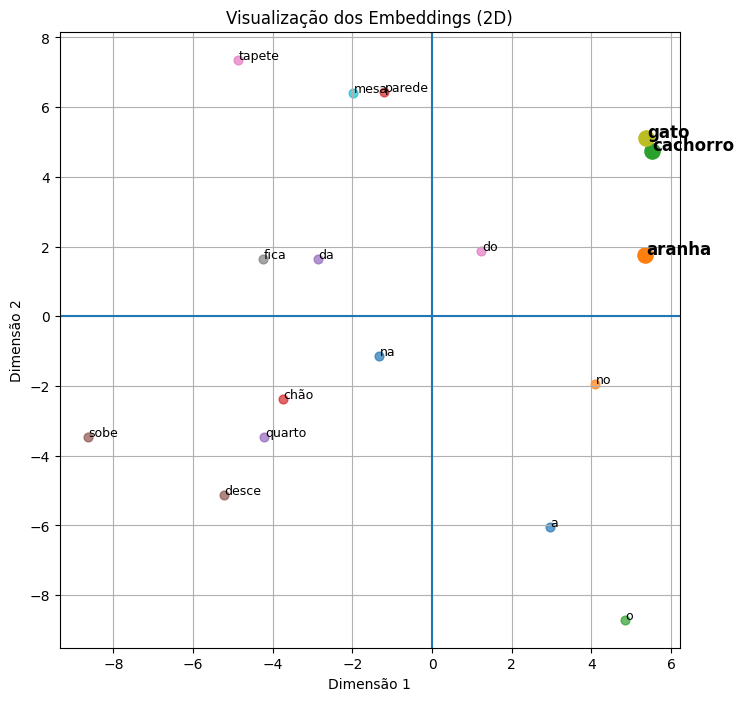

In [25]:
# Criar dicionário palavra -> embedding 2D
embeddings_2d = {
    palavra: modelo.W[idx]
    for palavra, idx in word_to_ix.items()
}

plot_embeddings(
    embeddings_2d,
    highlight=["gato", "cachorro", "aranha"]
)